## Customer Churn Prediction 
by Ori Rosenthal

### Introduction:<br>
Customer retention is one of the key aspects of <b>C</b>ustomer <b>R</b>elationship <b>M</b>anagement. 


Customer churn (aka, customer attrition, customer turnover, or customer defection) is the loss of clients or customers,<br>
and, customer churn rate, is the percentage of customers who have stopped using your company's product or service during a certain period of time.

Managing client churn is a major challenge facing companies, particularly those offering subscription-based services.

The goal is to predict customer churn using Machine Learning model. <br>Such models will create a list of customers that are most susceptible to churn, so that they can be given priority to a targeted customer retention plan.

This case study modeling based on telco-customer-churn dataset from Kaggle, with over 7000 customers (rows), and each column contains customer’s attributes (features).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix,roc_auc_score, roc_curve,precision_recall_curve
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold,GridSearchCV
from sklearn.metrics import f1_score, precision_score,recall_score,accuracy_score, plot_roc_curve, cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import plotly.offline as py 
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import eli5
pd.options.mode.chained_assignment = None
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Visualization

def churnratio():
    
    val = df["Churn"].value_counts().values.tolist()

    trace = go.Pie(labels = ["Not Churned","Churned"] ,
                   values = val ,
                   marker = dict(colors =  [ 'royalblue' ,'lime']), hole = .5)
    layout = go.Layout(dict(title = "Train Dataset Customers"))
    data = [trace]
    fig = go.Figure(data = data,layout = layout)
    py.iplot(fig)

def report(y_true, y_pred):
    print("Accuracy = " , accuracy_score(y_true, y_pred).round(3))
    print("Precision = " ,precision_score(y_true, y_pred).round(3))
    print("Recall = " ,recall_score(y_true, y_pred).round(3))
    print("F1 Score = " ,f1_score(y_true, y_pred).round(3))
    print("Cohen kappa = " ,cohen_kappa_score(y_true, y_pred).round(3))

In [3]:
# Import dataset 

df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

Let's look at the first 5 rows

In [4]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
print(f'Dataset contains {df.shape[0]} rows, and {df.shape[1]} columns.')

Dataset contains 7043 rows, and 21 columns.


## Content
#### Each row represents a customer, each column contains customer’s attributes.

The data set includes information about:

* Customers who left within the last month – the column is called <b>Churn</b>.<br>
* Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies.<br>
* Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges.<br>
* Demographic info about customers – gender, age range, and if they have partners and dependents.

In [6]:
# Inspect all the features data types and missing values
pd.concat([df.dtypes,df.isna().sum(),df.nunique()],axis=1).rename(columns={0: "Types", 1: "Nulls", 2:'Nunique'})

,Types,Nulls,Nunique
customerID,object,0,7043
gender,object,0,2
SeniorCitizen,int64,0,2
Partner,object,0,2
Dependents,object,0,2
tenure,int64,0,73
PhoneService,object,0,2
MultipleLines,object,0,3
InternetService,object,0,3
OnlineSecurity,object,0,3


In [7]:
df.drop('customerID', axis=1, inplace=True)
# Replace spaces with null values in column of total charges
df['TotalCharges'] = df["TotalCharges"].replace(" ",np.nan).astype(float)
print(f'TotalCharges number of Nan values: {df["TotalCharges"].isna().sum()}')
print(f'TotalCharges percentage of Nan values: {np.round(df["TotalCharges"].isna().sum()/len(df)*100,3)}%')


TotalCharges number of Nan values: 11
TotalCharges percentage of Nan values: 0.156%


In [8]:
# Fill misiing values with midian
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

In [9]:
# Describe statistis for numerical features
df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.16,0.37,0.00,0.00,0.00,0.00,1.00
tenure,7043.0,32.37,24.56,0.00,9.00,29.00,55.00,72.00
MonthlyCharges,7043.0,64.76,30.09,18.25,35.50,70.35,89.85,118.75
TotalCharges,7043.0,2281.92,2265.27,18.80,402.22,1397.48,3786.60,8684.80


## Let's explore our dataset

In [10]:
churnratio()

26.5% churn rate 

We'll start with the <b>numerical features</b>, and look at the distribution for those who've been churned, and for those who haven't.

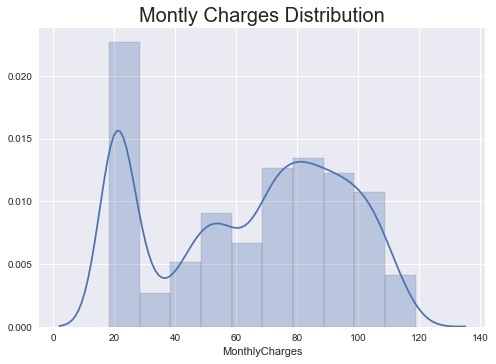

In [11]:
plt.style.use('seaborn')
plt.title("Montly Charges Distribution",size=20)
sns.distplot(df['MonthlyCharges'],bins=10,hist_kws={'edgecolor':'black','alpha':.3});

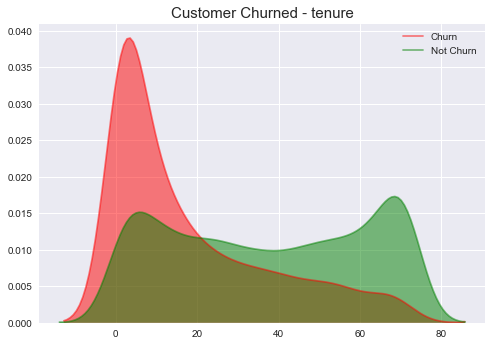

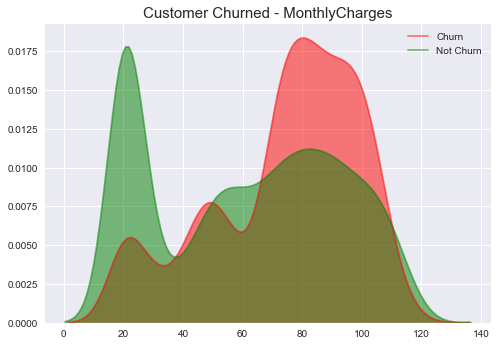

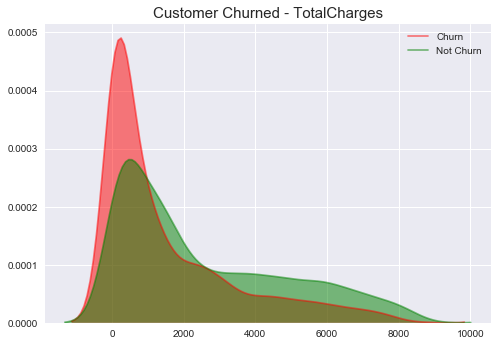

In [12]:
for i in ('tenure','MonthlyCharges', 'TotalCharges'):
    
    sns.kdeplot(df[df['Churn']=='Yes'][str(i)], color='r', shade=True, label = 'Churn', alpha=0.5)
    sns.kdeplot(df[df['Churn']== 'No'][str(i)], color='g', shade=True, label = 'Not Churn', alpha=0.5)
    plt.title(f'Customer Churned - {i}', size=15)
    plt.show()

 We can already see from those plots that:
* Recent customers will be more likely to churn
* Customers with higher monthly charges often have a greater risk of churning


### Now, let 's explore the categorical features and their relationship to our variable target.

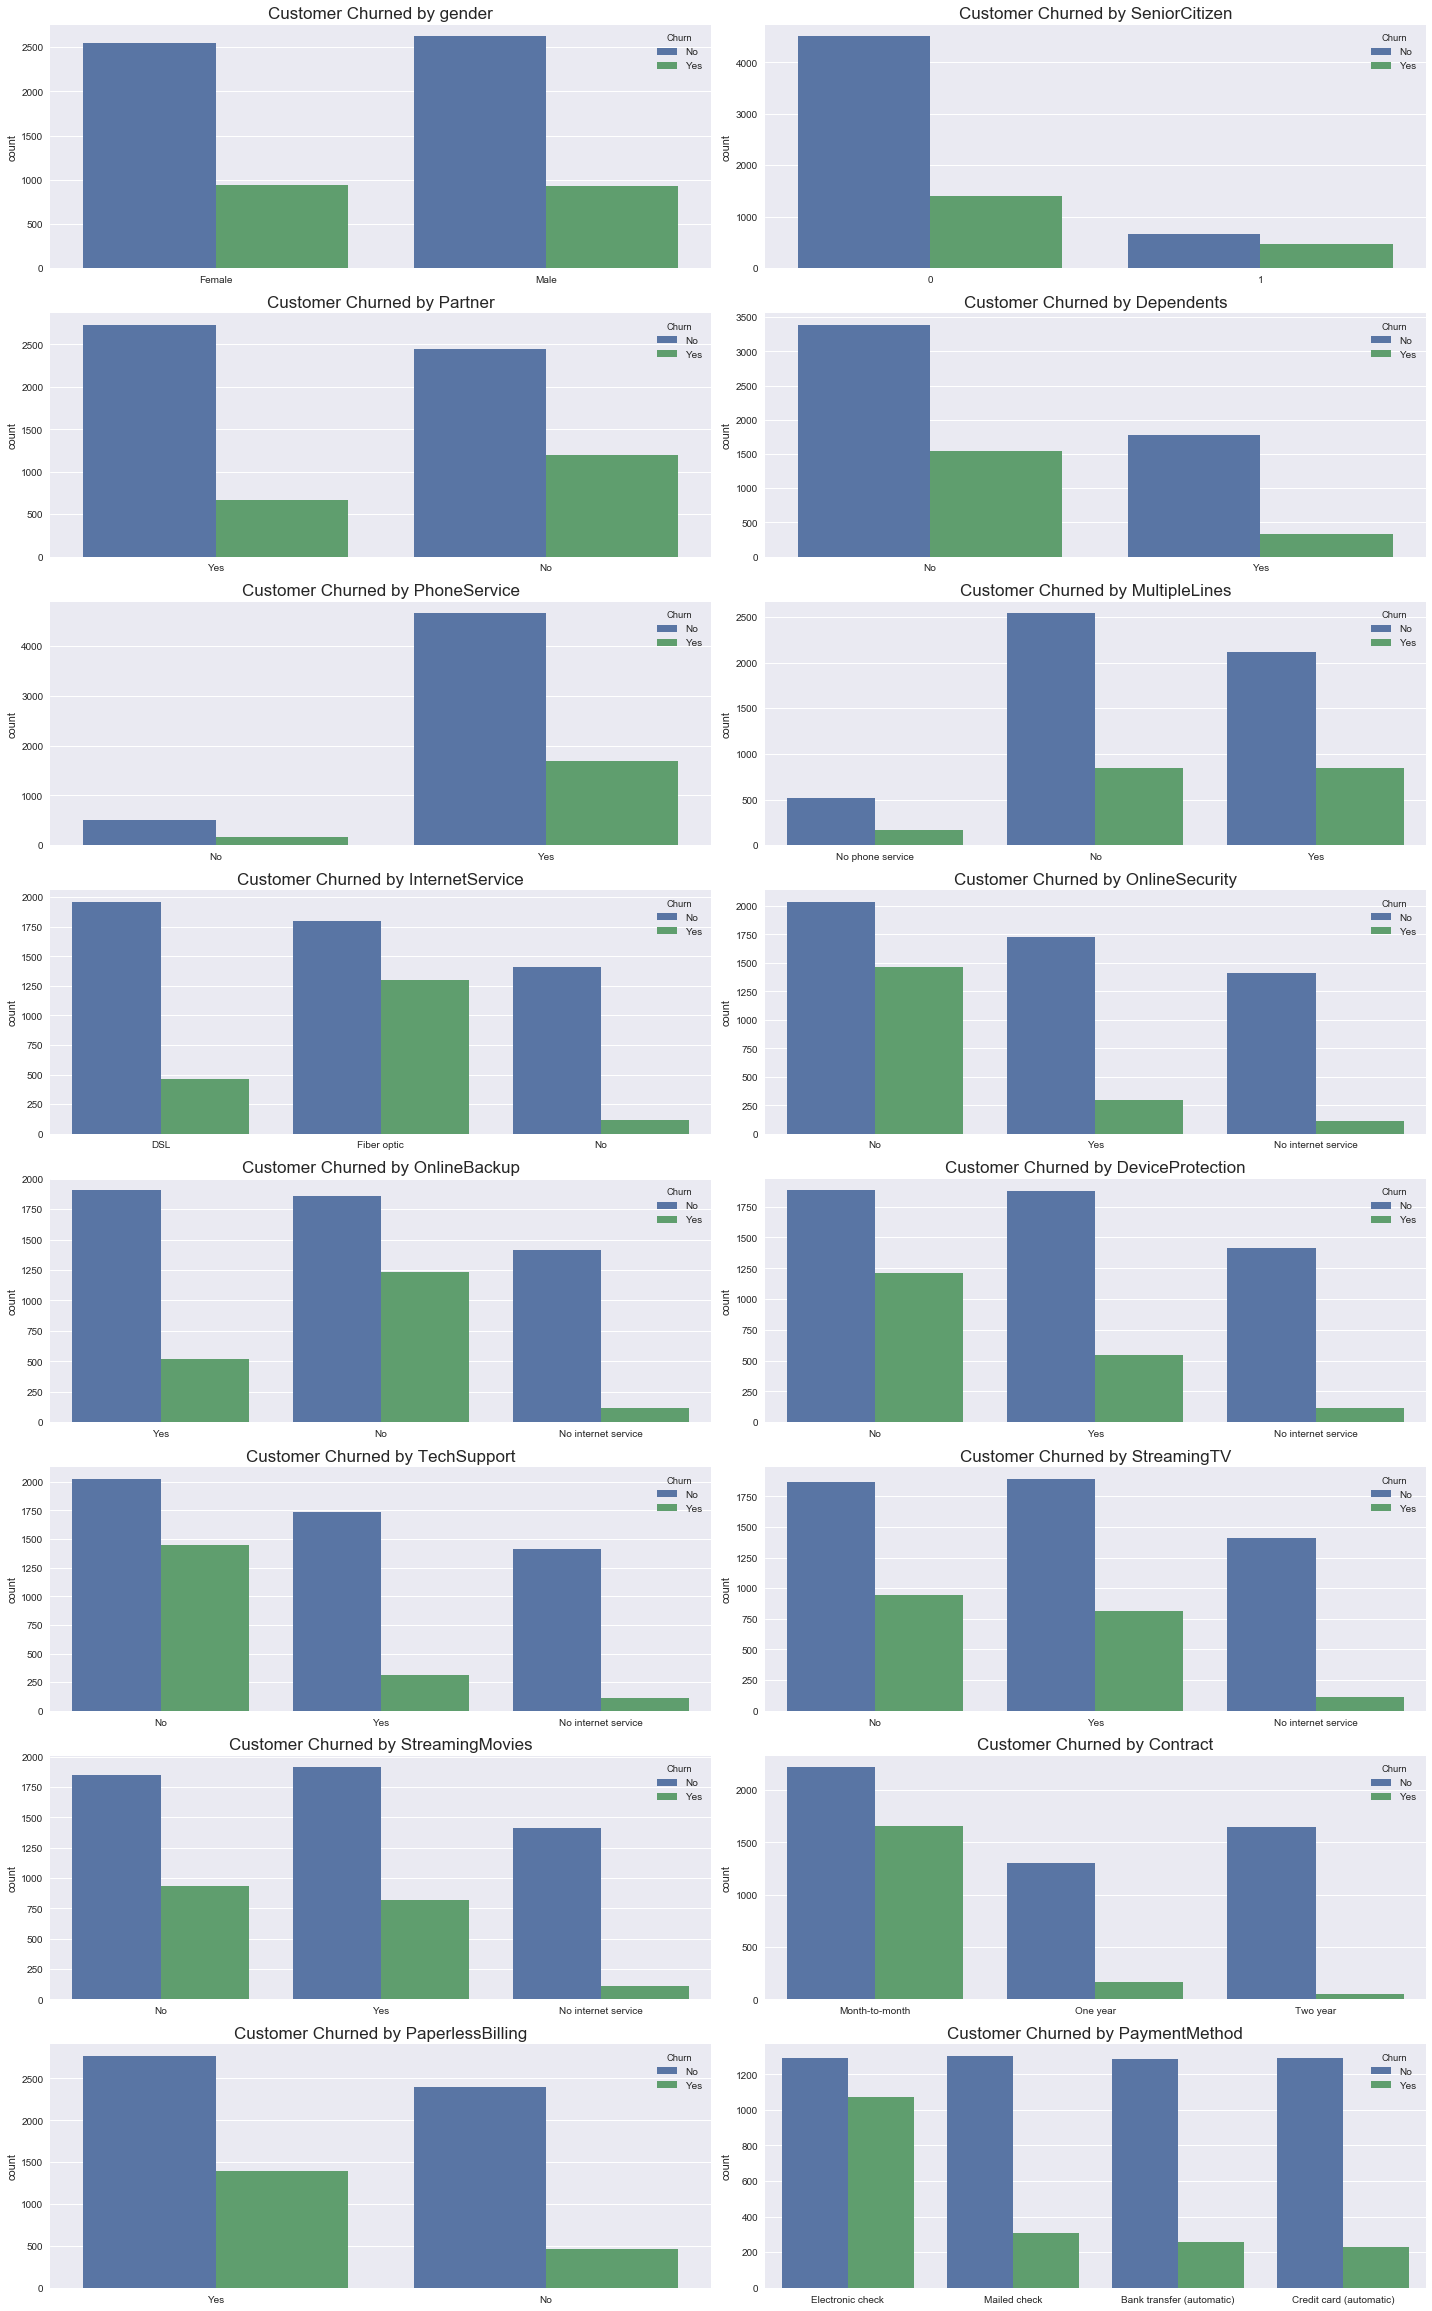

In [13]:
plt.subplots(figsize = (20, 40))

for n, i in enumerate(df.columns[df.nunique() <5].drop('Churn')):
    
    plt.subplot(10, 2, n+1)
    sns.countplot(df[i], hue='Churn', data=df);
    plt.title(f'Customer Churned by {i}', size=17)
    plt.xlabel("");
    plt.tight_layout()


<b><u>To summarize the categorical features, we can see that</u>:</b>

* SeniorCitizens have a greater degree of churn.
* Customers without partner have higher churn rate as well costumers without dependents.
* Customers with Fiber optic internet service are more probable to churn than others.
* Costumers without online security, back-up and device protection are more likely to churn.
* No technical support can be a churn indicator.
* Short-term contracts are subject to higher churn rates.
* Customers with paperless billing are more likely to churn.
* As far as payment methods, the electronic check has a very high churn rate.



###  Let's look at Correlation between the features

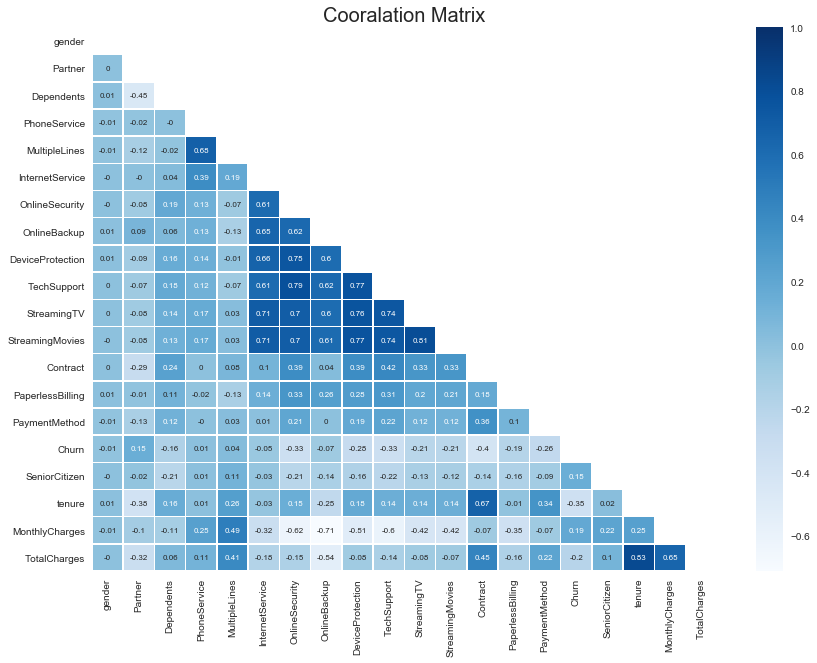

In [14]:
# In order to get all the correlation between the features, I first factorized the features of the object type,
# and then I joined the numerical data types.
corr = (df.select_dtypes(include='object').apply(lambda x: pd.factorize(x)[0])\
       .join(df.select_dtypes(include=['float','int64']))).corr().round(2)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(14, 10))
    ax = sns.heatmap(corr,mask=mask, cmap='Blues',annot=True,annot_kws={"size":8},linewidths=0.5);
    sns.set(font_scale=1.5);
    plt.title('Cooralation Matrix', size=20);

We see that there is a high correlation between the additional services,<br>that is, if someone is already adding one service then the likelihood of adding more services is high.

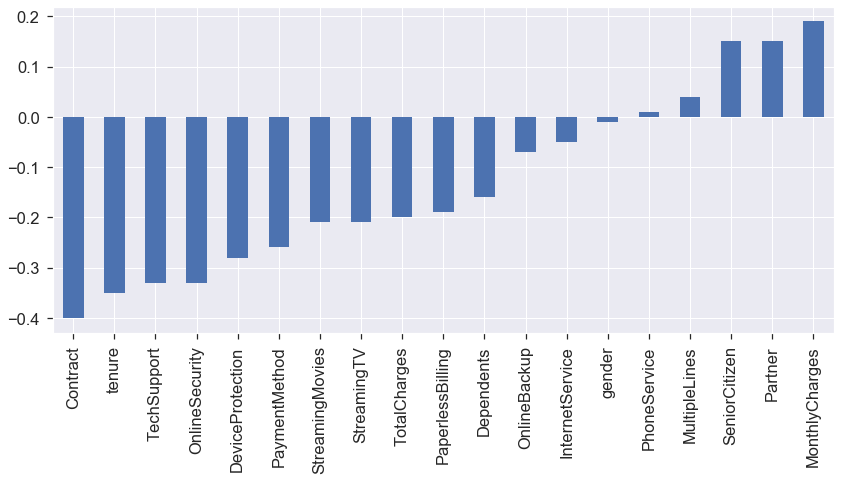

In [15]:
# Correlation of Churn with other variables
corr['Churn'].drop('Churn').sort_values().plot(kind='bar', figsize=(14,6));

<b><u>Data preprocessing</u></b>

In [16]:
# Transform the target to numerical variable 

df['Churn'] = df['Churn'].map({'No':0, 'Yes':1})

# grouping features by type (numerical, categorical)

num_features = df.drop(['Churn','SeniorCitizen'], axis=1).select_dtypes(include=['int64','float']).columns.tolist()
cat_features = df.select_dtypes(include='object').columns.tolist()

# Convert categorical variable into dummy/indicator variables.

df = pd.get_dummies(df, columns=cat_features)

In [17]:
# Splitting the data-set into independent (Churn) and dependent features

X = df.drop('Churn', axis=1)
y = df.Churn.values

# Split the dataset into train (60%), validate(20%), test (20%)
# We'll use stratify parameter to ensure the proportion of the class labels in each subset is the same.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=10)
X_train, X_val, y_train, y_val   = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=10)
print(f'training set: {X_train.shape[0]}')
print(f'validation set: {X_val.shape[0]}')
print(f'testing set: {X_test.shape[0]}')

training set: 4225
validation set: 1409
testing set: 1409


In [18]:
# StandardScaler tranform on numerical features in train and validation set 

sc = StandardScaler()
for i in num_features:
    X_train[i] = sc.fit_transform(X_train[i].values.reshape(-1,1))
    X_test[i]  = sc.transform(X_test[i].values.reshape(-1,1))
    X_val[i]   = sc.transform(X_val[i].values.reshape(-1,1))


In [19]:
# Because we have moderate imbalance (26.5% churn rate), we will use SMOTE(Synthetic Minority Over-sampling Technique)

sm = SMOTE(random_state=4)
X_train_smote, y_train_smote = sm.fit_sample(X_train, y_train)
print('y_train proportion of classes before:',np.bincount(y_train))
print('y_train proportion of classes with SMOTE:', np.bincount(y_train_smote))

y_train proportion of classes before: [3104 1121]
y_train proportion of classes with SMOTE: [3104 3104]


### Models

Now, we are going to make a comparison between various methods of machine learning.<br>
First, we'll create a dictionary of models with default setting, and one for training and predicting on val set<br>
Next, loop over each model while:<br>
* Making a pipeline for preprocessing the training data each time with SMOTE.<br>
* Evaluation by cross-validation (5 folds) on various performance metrics.<br>
* building a new dataframe for the results.
* Compare the results and visualize the ROC curves and the Confusion matrices for each of them.
* Choose 2 of our best models based on the relevant business matrices.
* Hyperparameter tuning for better results.
* Test the models with unseen data (testing set).

<u>Note</u>: We cross validate only on the training subsets (X_train_smote, y_train_smote),<br>
so essentially we take each time a proportion of the training data to validate our model,<br>
using the pipeline also protects us from data leakage.



In [20]:
# Creating ML-models dictionary (with default setting)

models={
    'LogReg'            : LogisticRegression(max_iter=1000),
    'DecisionTree'      : DecisionTreeClassifier(),
    'RandomForest'      : RandomForestClassifier(),
    'SVM'               : SVC(probability=True),
    'KNN'               : KNeighborsClassifier(),
    'AdaBoost'          : AdaBoostClassifier(),
    'XGBoost'           : XGBClassifier(),
    'LightGBM'          : LGBMClassifier(),
    
}

# Cross validation on train data

df_metrics=pd.DataFrame([])
predicts={}

for model_name in models.keys():
    
    metrics={}
    pipe = make_pipeline(sm, models[model_name])
    pred = models[model_name].fit(X_train_smote, y_train_smote)
    predicts[model_name] = pred.predict(X_val)
    metrics['accuracy']= cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy').mean()
    metrics['roc_auc'] = cross_val_score(pipe, X_train, y_train, cv=5, scoring='roc_auc').mean()
    metrics['precision'] = cross_val_score(pipe, X_train, y_train, cv=5, scoring='precision').mean()
    metrics['recall'] = cross_val_score(pipe, X_train, y_train, cv=5, scoring='recall').mean()
    metrics['f1'] = cross_val_score(pipe, X_train, y_train, cv=5, scoring='f1').mean()
    df_metrics=pd.concat([df_metrics,pd.DataFrame(metrics,index=[model_name]).T],axis=1)
    


df_metrics.T.style.highlight_max(color='lightgreen').set_precision(3)

,accuracy,roc_auc,precision,recall,f1
LogReg,0.791,0.845,0.601,0.637,0.618
DecisionTree,0.721,0.664,0.473,0.537,0.502
RandomForest,0.776,0.816,0.574,0.589,0.582
SVM,0.787,0.823,0.594,0.626,0.609
KNN,0.719,0.768,0.478,0.660,0.554
AdaBoost,0.767,0.846,0.544,0.749,0.630
XGBoost,0.774,0.840,0.558,0.712,0.625
LightGBM,0.776,0.825,0.576,0.593,0.585


<b>Comparing ROC Curves derived From our models</b>

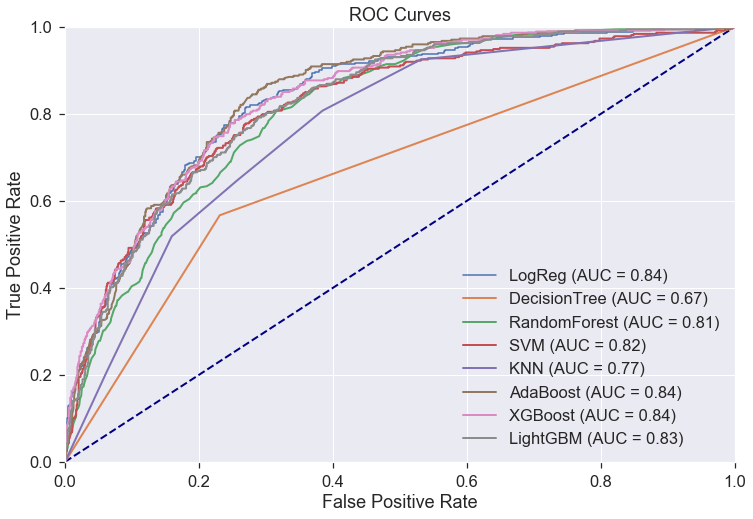

In [21]:
# Compare how well each algorithm used to identify true positive (sensitivity) vs. false positive (specificity).

model_test = {}
fig, ax = plt.subplots(figsize=(12,8))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--');
plt.title('ROC Curves'); ax.margins(0,0)

for n, model_name in enumerate(models.keys()):
  
    pipe = make_pipeline(sm, models[model_name])
    model_test[model_name] = pipe.fit(X_train, y_train)
    if n == 0:
        disp = plot_roc_curve(model_test[model_name], X_test,  y_test, name=model_name, ax=ax)
    else:
        plot_roc_curve(model_test[model_name], X_test, y_test, name=model_name, ax=disp.ax_, lw=2) 

roc_auc (the area under the ROC curve) evaluates the ability of the method to classify correctly,
and the classifier with the highest AUC score will be considered better.

<b>Comparing confusion matrices (validation set) derived from our models</b>

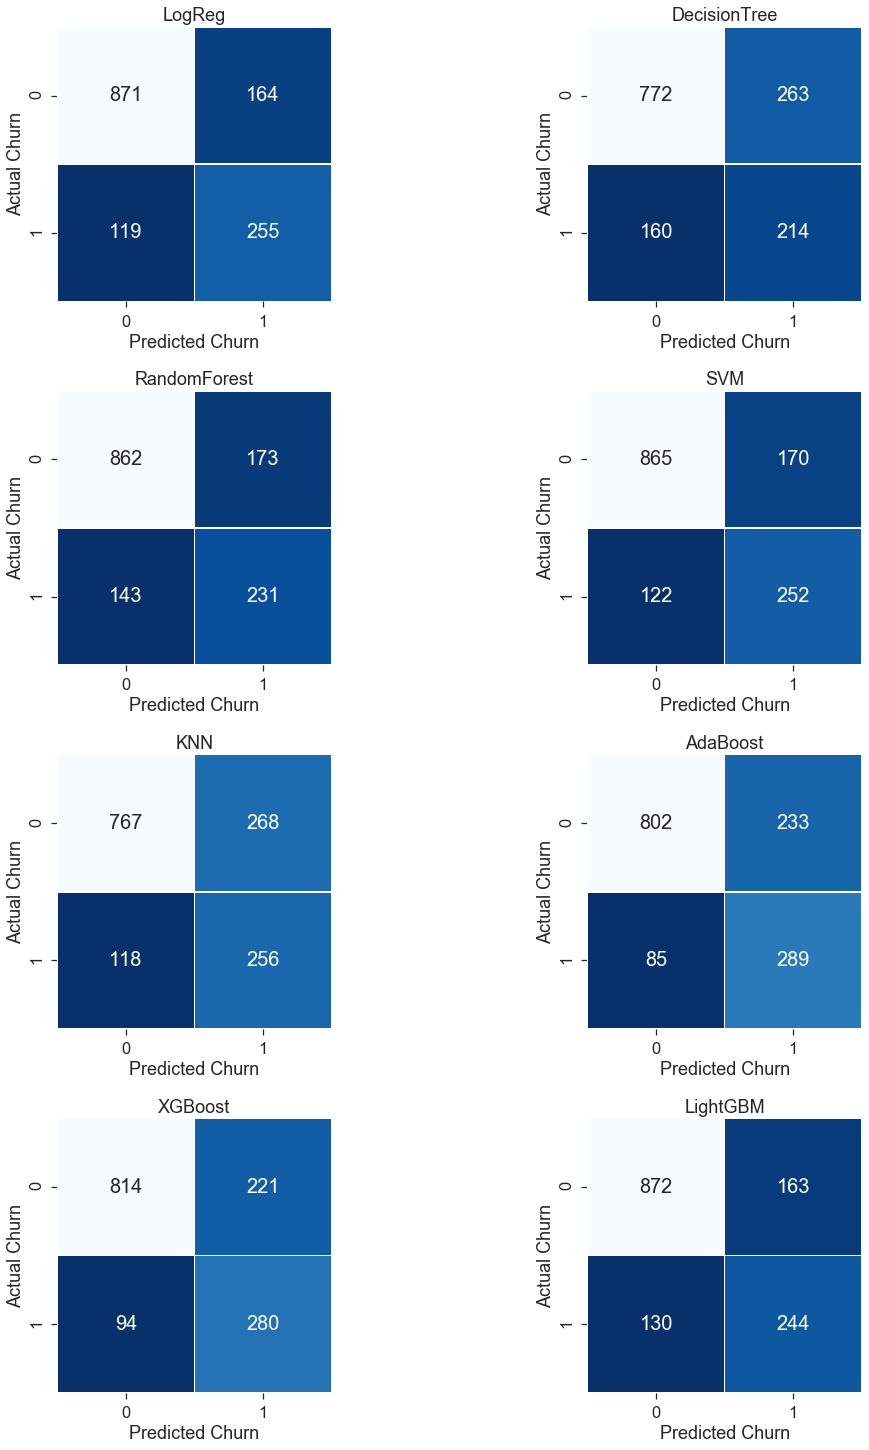

In [22]:
plt.subplots(figsize = (15, 40))

for n, model in enumerate(models.keys()):
    
    plt.subplot(8, 2, n+1)
    cm = confusion_matrix(y_val, predicts[model])
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True,
            cmap = 'Blues_r', cbar=False, annot_kws={"fontsize":20});
    plt.title(model)
    plt.ylabel('Actual Churn');
    plt.xlabel('Predicted Churn');
    plt.tight_layout()   

Having regard to the results of the auc score as well as the comparison of other metrics,<br>
we opt to proceed with <b><u>AdaBoost</u></b> and <b><u>Logistic Regression</u></b> models.

To maximize the performance of the models for our goal, let's first <b>explore</b> them, <b>tune</b> some hyperparameters,<br>
    and then <b>test</b> our model on the test data (X_test).

In [23]:
# Results of the models chosen from the cross validation process.

top_models = df_metrics.T.iloc[[0,5]].round(3)
top_models

,accuracy,roc_auc,precision,recall,f1
LogReg,0.791,0.845,0.601,0.637,0.618
AdaBoost,0.767,0.846,0.544,0.749,0.630


Our main objective is to predict whether a customer is going to churn,<br>
and the recall score is one of the moset relevent for that purpose.<br>
0.749 recall score, for AdaBoost model, means that for every 100 costumers that churn we're predicting 75 of them.<br>
Now, there's a trade-off between Recall (tp/(tp+fn) and Precision (tp/(tp+fp), means increasing one parameter leads to decreasing of the other.<br>
In our case (AdaBoost) high recall comes with low-precision, which means that for every 100 costumers that we predict as possibly churn,<br> only 54 of them will eventually be churned.<br>


<b>Feature selection</b>

In [24]:
# Let's sort all the features by correlation to the target
corr_features= abs(X.corrwith(df.Churn)).sort_values(ascending=False)
corr_features_to_test_var = corr_features.index.tolist()
corr_features.head()

Contract_Month-to-month        0.405103
tenure                         0.352229
OnlineSecurity_No              0.342637
TechSupport_No                 0.337281
InternetService_Fiber optic    0.308020
dtype: float64

Model name - best F1 score, Number of features
[('LogReg', 0.629, 24), ('AdaBoost', 0.633, 42)]


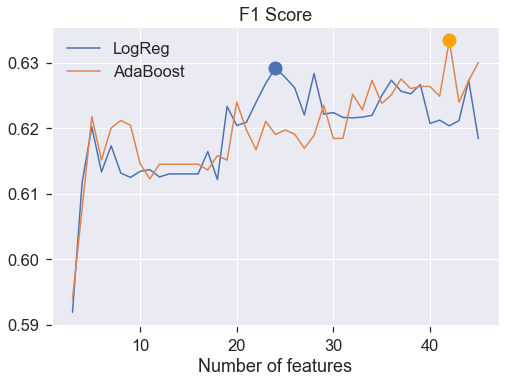

In [25]:
# loop from 3 to length of features list and add another feature each time
# cross-validate and store in a DataFrame

f1_results = pd.DataFrame(columns=top_models.index, index=np.arange(3,(len(corr_features))), dtype='int')

for n in range(3,len(corr_features_to_test_var)+1):
    X_train_f = X_train[corr_features_to_test_var[0:n]]
    
    for model in top_models.index:
        pipe = make_pipeline(sm, models[model])
        f1_results.loc[n,str(model)] = cross_val_score(pipe, X_train_f, y_train, cv=5, scoring='f1').mean()
        
print('Model name - best F1 score, Number of features')
print([(x, round(f1_results[x].max(),3), f1_results[x].idxmax()) for x in f1_results.columns])
f1_results.plot();
plt.title('F1 Score');plt.xlabel('Number of features');
plt.plot(f1_results.iloc[:,0].idxmax(), f1_results.iloc[:,0].max(), 'o', markersize=10,c="b", mew=4,)
plt.plot(f1_results.iloc[:,1].idxmax(), f1_results.iloc[:,1].max(), 'o', markersize=10, c="orange", mew=4);

<b>Hyperparameter Tuning (using validation set), testing results (unseen data - X_test) and, feature Importance</b>

<b>AdaBoost</b>

In [26]:
# before tuning hyperparameter
ada_clf = AdaBoostClassifier().fit(X_train_smote, y_train_smote)
clf_pred = ada_clf.predict(X_val)
report(y_val, clf_pred)

Accuracy =  0.774
Precision =  0.554
Recall =  0.773
F1 Score =  0.645
Cohen kappa =  0.486


In [27]:
# Adaboost - try to tune:
# n_estimators: Number of weak learners to train iteratively.
# learning_rate: the rate at which we are adjusting the weights of our model with respect to the loss gradient
#            
param_grid = [{'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.5], 'n_estimators': [25, 50, 70, 100]}]
gs = GridSearchCV(models['AdaBoost'], param_grid, cv=5, n_jobs=-1, scoring='f1')
gs.fit(X_train_smote, y_train_smote)
print('grid search best params:',gs.best_params_)
ada_clf_gs = AdaBoostClassifier(learning_rate=0.5, n_estimators=100).fit(X_train_smote, y_train_smote)
clf_pred = ada_clf_gs.predict(X_val)
report(y_val, clf_pred)

grid search best params: {'learning_rate': 0.5, 'n_estimators': 100}
Accuracy =  0.76
Precision =  0.532
Recall =  0.799
F1 Score =  0.639
Cohen kappa =  0.47


In [28]:
### 
ada_clf = AdaBoostClassifier().fit(X_train_smote, y_train_smote)
ada_clf_pred = ada_clf.predict(X_test)
report(y_test, ada_clf_pred)

Accuracy =  0.766
Precision =  0.543
Recall =  0.749
F1 Score =  0.629
Cohen kappa =  0.464


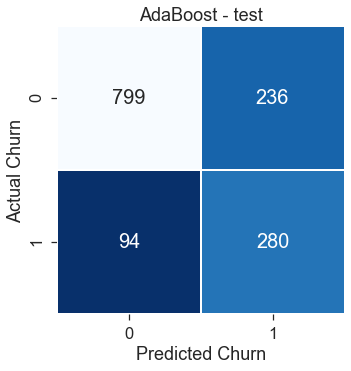

In [29]:
cm = confusion_matrix(y_test, ada_clf_pred)
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True,
        cmap = 'Blues_r', cbar=False, annot_kws={"fontsize":20});
plt.title('AdaBoost - test')
plt.ylabel('Actual Churn');
plt.xlabel('Predicted Churn');
plt.tight_layout()   

AdaBoost model, Confusion matrix results for test data:
* 75% of churned customers predicted correctly (recall).
* 54% of the churn predictions are correct (precision).

Showing AdaBoost model weights for each feature, showing how influential it might have been to contribute to the final decision:

In [30]:
eli5.explain_weights(ada_clf, top=25, feature_names = X.columns.tolist())

Weight,Feature
0.1200 ± 0.6499,tenure
0.0800 ± 0.5426,PaymentMethod_Mailed check
0.0800 ± 0.5426,Contract_Month-to-month
0.0800 ± 0.5426,PaymentMethod_Electronic check
0.0600 ± 0.4750,PaymentMethod_Credit card (automatic)
0.0600 ± 0.4750,PaymentMethod_Bank transfer (automatic)
0.0600 ± 0.4750,Dependents_Yes
0.0600 ± 0.4750,gender_Male
0.0600 ± 0.4750,gender_Female
0.0400 ± 0.3919,Dependents_No


<b>Logistic Regression</b>

In [31]:
# before tuning hyperparameter
lr_clf_val = LogisticRegression(max_iter=1000).fit(X_train_smote, y_train_smote)
clf_pred = lr_clf_val.predict(X_val)
report(y_val, clf_pred)

Accuracy =  0.799
Precision =  0.609
Recall =  0.682
F1 Score =  0.643
Cohen kappa =  0.504


In [32]:
# Logistic Regression - try to tune:
# C: controls the inverse of the regularization strength.
# solver
#            
param_grid = [{'C': [0.1, 0.5, 0.75, 1, 10], 'solver': ['lbfgs', 'saga']}]
gs = GridSearchCV(models['LogReg'], param_grid, cv=5, n_jobs=-1, scoring='f1')
gs.fit(X_train_smote, y_train_smote)
print('grid search best params:',gs.best_params_)
lr_clf_gs = LogisticRegression(max_iter=1000, C=0.75).fit(X_train_smote, y_train_smote)
clf_pred = lr_clf_gs.predict(X_val)
report(y_val, clf_pred)

grid search best params: {'C': 0.75, 'solver': 'lbfgs'}
Accuracy =  0.8
Precision =  0.61
Recall =  0.684
F1 Score =  0.645
Cohen kappa =  0.506


In [33]:
# 
lr_clf_test = LogisticRegression(max_iter=1000).fit(X_train_smote, y_train_smote)
lr_clf_pred = lr_clf_test.predict(X_test)
report(y_test, lr_clf_pred)

Accuracy =  0.78
Precision =  0.577
Recall =  0.639
F1 Score =  0.607
Cohen kappa =  0.454


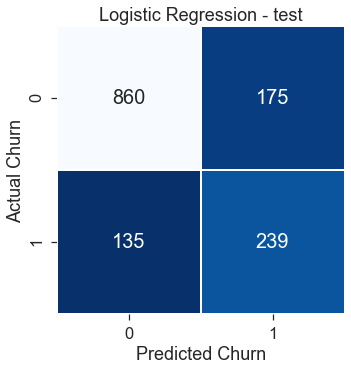

In [34]:
cm = confusion_matrix(y_test, lr_clf_pred)
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True,
        cmap = 'Blues_r', cbar=False, annot_kws={"fontsize":20});
plt.title('Logistic Regression - test')
plt.ylabel('Actual Churn');
plt.xlabel('Predicted Churn');
plt.tight_layout()   

Logitic Regresion model, Confusion matrix results for test data:
* 64% of churned customers predicted correctly (recall).
* 58% of the churn predictions are correct (precision).

Showing Logistic Regression model weights for each feature, showing how influential it might have been to contribute to the final decision:

In [35]:
eli5.explain_weights(lr_clf_test, top=50, feature_names = X.columns.tolist())

Weight?,Feature
+27.046,<BIAS>
+1.144,TotalCharges
+0.977,MonthlyCharges
+0.122,SeniorCitizen
+0.121,PhoneService_Yes
-0.459,MultipleLines_No phone service
-0.459,PhoneService_No
-1.204,Contract_Month-to-month
-1.357,InternetService_DSL
-1.371,InternetService_Fiber optic


Let's explore our Logistic Regression model with the precision-recall curve that shows the tradeoff between precision and recall for different threshold.

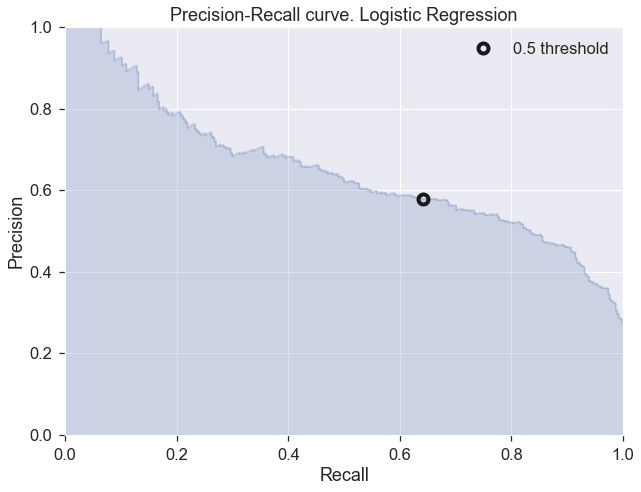

In [36]:
lr_clf_val = LogisticRegression(max_iter=1000).fit(X_train_smote, y_train_smote)
clf_pred_proba = lr_clf_val.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, clf_pred_proba)

mark = np.argwhere(thresholds == min(thresholds, key=lambda x:abs(x-0.5)))
plt.figure(figsize=(10,7.5))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.plot(recall[mark], precision[mark], 'o', markersize=10,label="0.5 threshold", fillstyle="none", c="k", mew=4)
plt.fill_between(recall, precision, alpha=0.2, color='b')
plt.title('Precision-Recall curve. Logistic Regression')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0]); plt.legend(loc=1);

One other way to visualize the data is to use the x-axis as the threshold, and plot the precision and recall:

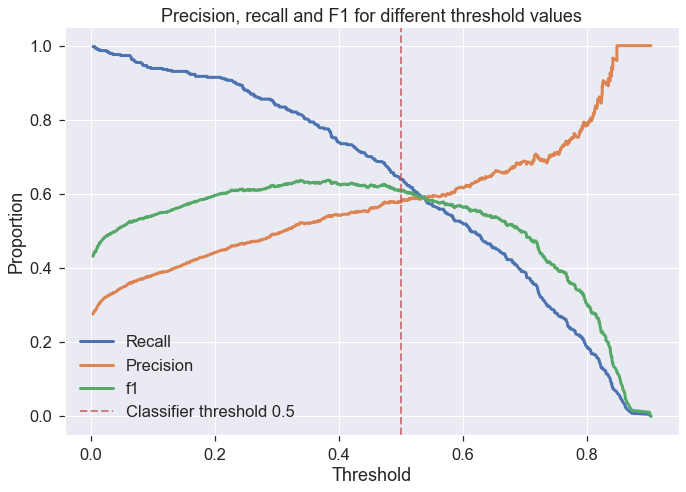

In [37]:
# Logistic Regression Precision, recall and F1 for different threshold values.
precision, recall, thresholds = precision_recall_curve(y_test, clf_pred_proba)
plt.figure(figsize=(11,7.5))
plt.plot(thresholds, recall[1:], label="Recall",linewidth=3)
plt.plot(thresholds, precision[1:], label="Precision",linewidth=3);
plt.plot(thresholds, (2 * (precision[1:] * recall[1:]) / (precision[1:] + recall[1:])), label="f1",linewidth=3);
plt.title('Precision, recall and F1 for different threshold values');
plt.xlabel('Threshold');plt.ylabel('Proportion')
plt.axvline(x=0.5,color='r', lw=2, linestyle='--', alpha=0.7, label='Classifier threshold 0.5');
plt.legend();

<b>From the chart above and as far as business objectives are concerned, <br>we can adjust our model classification threshold (decision threshold) to maximize the F1-Score (weighted average of Precision and Recall) in order to achieve higher recall rate, with the cost of higher false positive.
The main assumptions here are that acquiring a new customer is between five and 25 times more expensive than retaining an existing one,<br>
and increasing customer retention rates, even with a small portion, can significantly increase company profits</b>

In [38]:
f1 = (2 * (precision[1:] * recall[1:]) / (precision[1:] + recall[1:]))
adjusted_threshold = thresholds[np.argmax(f1)].round(3)
print(f'Currently F1 score: {f1_score(y_test, lr_clf_pred).round(3)}')
print(f'Max F1 score: {np.max(f1).round(3)}')
print(f'New adjusted classifier threshold: {adjusted_threshold}')

Currently F1 score: 0.607
Max F1 score: 0.637
New adjusted classifier threshold: 0.383


Accuracy =  0.766
Precision =  0.541
Recall =  0.775
F1 Score =  0.637
Cohen kappa =  0.472


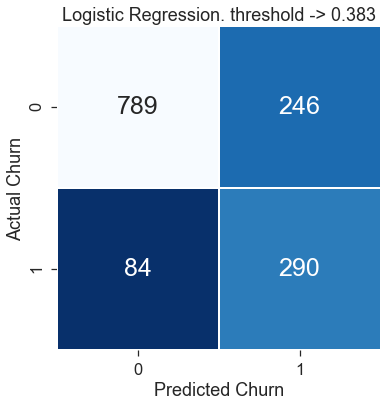

In [39]:
lr_clf_test = LogisticRegression(max_iter=1000).fit(X_train_smote, y_train_smote)
lr_clf_decision_thr =(lr_clf_test.predict_proba(X_test)[:,1] > adjusted_threshold)
cm = confusion_matrix(y_test, lr_clf_decision_thr)
plt.subplots(figsize = (8,6))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True,cmap = 'Blues_r', cbar=False, annot_kws={"fontsize":25});
plt.title(f'Logistic Regression. threshold -> {adjusted_threshold}')
plt.ylabel('Actual Churn');plt.xlabel('Predicted Churn');plt.tight_layout();
report(y_test, lr_clf_decision_thr)

<b> Decile analysis & Lift</b>

,min_prob,max_prob,#customers,churn,%d_churn_rate,%g_churn_rate,%base_rate,lift,d_churn_rate
Decile,,,,,,,,,
1,0.77,0.90,134,98,0.73,0.26,0.265,2.75,0.73
2,0.64,0.76,141,78,0.55,0.21,0.265,2.08,0.55
3,0.50,0.63,145,66,0.46,0.18,0.265,1.74,0.46
4,0.37,0.49,140,52,0.37,0.14,0.265,1.40,0.37
5,0.26,0.36,138,33,0.24,0.09,0.265,0.91,0.24
6,0.16,0.25,143,20,0.14,0.05,0.265,0.53,0.14
7,0.08,0.15,133,10,0.08,0.03,0.265,0.30,0.08
8,0.04,0.07,128,9,0.07,0.02,0.265,0.26,0.07
9,0.02,0.03,96,3,0.03,0.01,0.265,0.11,0.03


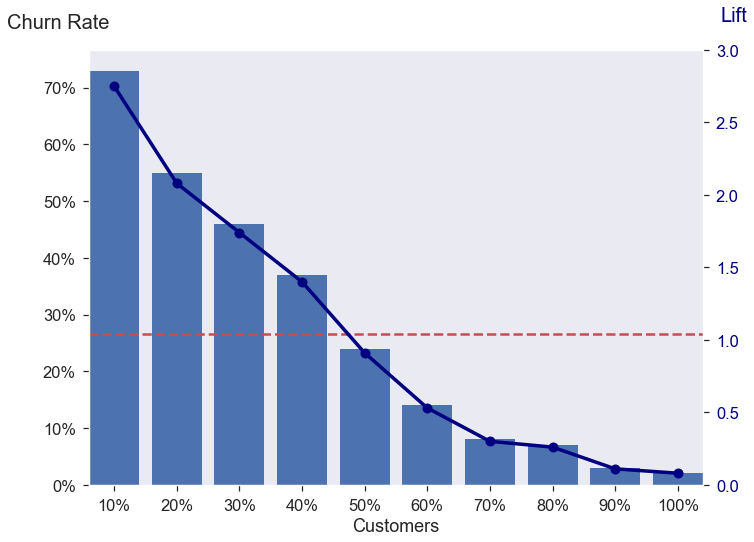

In [40]:
# divides a data series into 10 parts, and group based on the predicted churn probability (value between 0.0 and 1.0).
# in ascending order, that first decile contain highest probability score, and then calculate the true churn rate per group.

lift = pd.DataFrame({'Churn':y_test,
                     'Pred':lr_clf_test.predict_proba(X_test)[:,1].round(2)})
grouped = lift.groupby(pd.qcut(lift['Pred'],10,labels=False)+1)
lift_df = pd.DataFrame()
lift_df['min_prob'] = grouped.min()['Pred']
lift_df['max_prob'] = grouped.max()['Pred']
lift_df['#customers'] = grouped.size()
lift_df['churn'] = grouped.sum()['Churn']
lift_df['%d_churn_rate'] = round(grouped.sum()['Churn'] / grouped.size(),2)
lift_df['%g_churn_rate'] = round(lift_df['churn']/y_test.sum(),2)#.apply('{:.0%}'.format)
lift_df['%base_rate'] = round(y_test.mean(),3)
lift_df['lift'] = round(lift_df['%d_churn_rate'] / lift_df['%base_rate'],2)
lift_df = lift_df.sort_values(by="min_prob", ascending=False)
lift_df['d_churn_rate'] = lift_df['%d_churn_rate']#.apply('{:.0%}'.format)
lift_df.index = range(1,11)
lift_df.index.rename('Decile', inplace=True)
fig, ax = plt.subplots(figsize=(11,8))
plt.bar(lift_df.index,lift_df['%d_churn_rate']);
plt.xlabel('Customers'); plt.ylabel('Churn Rate');plt.xticks(lift_df.index)
ax.set_ylabel('Churn Rate', fontsize=16,size=20, rotation=360, labelpad=35);
ax.yaxis.set_label_coords(-0.05,1.04)
ax.grid(False)
plt.axhline(lift_df['%base_rate'].mean(), color='r', linestyle='--', lw=2.5);
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]);
ax2 = ax.twinx()
plt.plot(lift_df.index,lift_df['lift'], lw=3.5, color='navy', marker='.', markersize=20)
plt.margins(0,0);ax2.grid(False); plt.ylim(0,3);plt.ylabel('Lift')
plt.gca().set_xticklabels(['{:.0f}%'.format(x*10) for x in plt.gca().get_xticks()]);
plt.yticks(color='navy')
ax2.set_ylabel('Lift', fontsize=16, color='navy', size=20, rotation=360, labelpad=35);
ax2.yaxis.set_label_coords(+1.05,1.1)
lift_df

If we only target 10% of the customers in the first group (that has the higher probability of 0.77	to 0.90), we can expect to catch nearly three times more churning customers than we would by targeting the same number of people randomly. The churn customers in the first group account for 26% of all churn customers.

<b><u>Summary</u><b>

<b>The exploratory data analysis provided us with business understanding what features are related to customer's churn.<br>This can provide actionable insights that can help to make product, pricing and marketing decisions more effective.<br>
The company for example can re-price or stop providing fiber optics internet service, as well as lower monthly charges for new customers.<br>
As, for the models, the company can implement one or multiple churn prediction models (Ensemble) ,<br>and then combine them to increase customer retention for more profitability results.</b>